# Tutorial

This notebook provides a basic tutorial on how to implement basic tasks using [AttentionDCA.jl](https://github.com/pagnani/AttentionDCA.jl). We assume we have multiple MSA in fasta format with the respective structural data given as a list of elements $(i,j,d_{ij})$ where $d_{ij}$ is the distance in Angstroms between residues $(i,j)$, as in: 
<pre> 
    11.0 35.0 1.957165
    21.0 28.0 1.94592
    6.0 19.0 3.262827
    .
    .
    .
</pre> 

The tasks we are interested in are:
1. Infer the $(Q,K,V)$ matrices for a single family.
2. Infer the contacts from a $(Q,K,V)$ using the Frobenious score and the Attention score.
3. Generate sample from the autoregressive model.
4. Infer the $(Qs, Ks)$ matrices from multiple families and the $V$ matrix shared among them. Then infer the contacts.

All the results in this tutorial make use of the fasta and structure files in `data`. These are a light alingment based on PF00014. The full families used in the paper [Direct Coupling Analysis and the Attention Mechanism](https://www.biorxiv.org/content/10.1101/2024.02.06.579080v2) can be found at [DataAttentionDCA](https://github.com/francescocaredda/DataAttentionDCA) inside the `data` folder. 

## Installing the software

1. Instal [Julia](https://julialang.org/downloads/)
2. Add the PyPlot and IJulia package and then activate this notebook:
<pre> 
julia> using Pkg
julia> Pkg.add("PyPlot")
julia> Pkg.add("IJulia")
julia> using IJulia
julia> notebook()
</pre> 
This should open a page on your default browser and from there you should navigate to this notebook.

## Run the notebook

In [ ]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/CODE/AttentionDCA.jl`
Precompiling project...


In [6]:
using AttentionDCA
using PyPlot #or alternatively Plots
include("useful_functions.jl");

Precompiling AttentionDCA
  ✓ AttentionDCA
  1 dependency successfully precompiled in 9 seconds. 185 already precompiled.
[ Info: Precompiling AttentionDCA [501c1ba2-c59e-46b0-b79a-24a850114dc9]
[ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
[ Info: Precompiling ZygoteColorsExt [e68c091a-8ea5-5ca7-be4f-380657d4ad79]


## 1. Infer the $(Q,K,V)$ matrices for a single family.

In [15]:
out_std = trainer("../data/PF00014.fasta",100,H=128, d=5);

removing duplicate sequences... done: 4915 -> 3617
θ = 0.3581129355126962 threshold = 18.0
M = 3617 N = 53 Meff = 1435.5651179248357
preprocessing took 0.041929125 seconds
Epoch 1 loss = 1818.24114
Epoch 2 loss = 1689.74883
Epoch 3 loss = 1563.84737
Epoch 4 loss = 1443.85834
Epoch 5 loss = 1329.45726
Epoch 6 loss = 1221.16735
Epoch 7 loss = 1119.08232
Epoch 8 loss = 1023.07255
Epoch 9 loss = 933.19372
Epoch 10 loss = 849.31073
Epoch 11 loss = 771.32568
Epoch 12 loss = 699.17684
Epoch 13 loss = 632.8103
Epoch 14 loss = 572.19464
Epoch 15 loss = 517.23644
Epoch 16 loss = 467.76639
Epoch 17 loss = 423.47135
Epoch 18 loss = 383.92818
Epoch 19 loss = 348.69247
Epoch 20 loss = 317.34706
Epoch 21 loss = 289.53041
Epoch 22 loss = 264.89617
Epoch 23 loss = 243.13951
Epoch 24 loss = 223.96236
Epoch 25 loss = 207.0989
Epoch 26 loss = 192.29582
Epoch 27 loss = 179.33438
Epoch 28 loss = 168.00275
Epoch 29 loss = 158.11511
Epoch 30 loss = 149.50013
Epoch 31 loss = 142.00866
Epoch 32 loss = 135.49337

The output "out_std" is a structure containing the $(Q,K,V)$ matrices with dimensions $(H,d,L)$ for $Q$ and $K$, $(H,q,q)$ for $V$, where:<br>

$H=$number of heads<br>
$d=$internal dimension<br>
$q=$alphabet size<br>
$L=$family length<br>

E.g.

In [8]:
out_std.m.Q

32×23×53 Array{Float64, 3}:
[:, :, 1] =
  1.26972     0.36541     0.732473   …   0.990959   -0.028713    0.562689
 -0.0143197   0.330929    0.224807       0.948536    1.12792     0.532707
  0.496547   -0.339218    0.708489       0.551519    1.33219     0.270532
  0.0855425   0.804841    0.812687       1.03863     0.397245   -0.275914
  0.499388    0.175755   -0.246942       0.105045   -0.764295    0.752387
  0.136168    0.602523   -0.60951    …   0.263851    0.178749    1.14769
  1.11859     0.738842    0.775726       0.777442    1.14683     0.779474
  0.634038   -0.253895    0.505866       0.48499    -0.0861906   0.473598
  1.02687     1.1314      0.872429       0.440275    0.0516122   1.08704
  0.606316    0.41416     1.11897       -0.303986    0.924429    1.03814
  1.13307     1.00019     0.293591   …   1.02092     1.00675     0.624865
  0.580242   -0.0547082   0.500814       0.456012    0.992327    0.505045
  1.74016    -1.06108     0.810195      -0.614282    0.354642   -0.227721
 

## 2. Infer the contacts from a $(Q,K,V)$ using the Frobenious score and the Attention score.

The contact prediciton via Frobenious score is computed as in

In [16]:
s = score(out_std)

1128-element Vector{Tuple{Int64, Int64, Float64}}:
 (11, 35, 21.08529430793183)
 (21, 28, 10.659094900574134)
 (17, 41, 9.204658535544468)
 (10, 33, 3.6882658439114184)
 (17, 43, 2.1829621880313335)
 (10, 36, 1.8924715960575593)
 (19, 28, 1.8665275008530051)
 (15, 33, 1.6030391783876727)
 (9, 37, 1.4198660348853558)
 (14, 33, 1.4092181949613525)
 (18, 45, 1.3854460815653211)
 (12, 33, 1.2745330849603431)
 (14, 31, 1.1621743319669005)
 ⋮
 (35, 41, -0.6877729388021848)
 (21, 35, -0.7185937927629082)
 (33, 41, -0.7206709134849643)
 (11, 21, -0.727431132042994)
 (11, 49, -0.7378401948818863)
 (17, 35, -0.7663441711765402)
 (11, 51, -0.7826639705007585)
 (28, 41, -0.7947427145907574)
 (11, 17, -0.7989802220460226)
 (11, 41, -0.8267070795328624)
 (28, 35, -0.8575790589502553)
 (11, 28, -1.0735376716659446)

The Positive Predicted Value can be computed by comparing the predicted contacts to the actual structure of the protein which can be found in `data/PF00014_struct.dat`

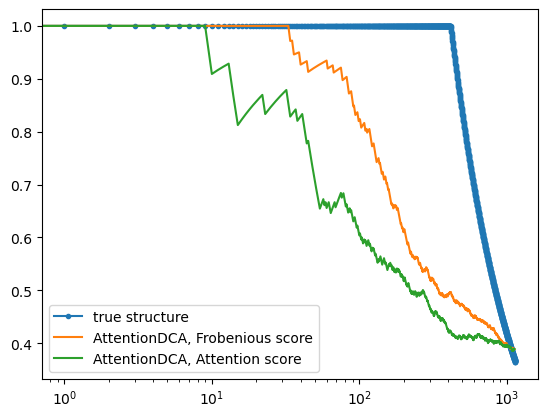

PyObject <matplotlib.legend.Legend object at 0x34897c580>

In [17]:
ppv_true = AttentionDCA.compute_actualPPV("../data/PF00014_struct.dat", min_separation=6)

ppv_frob = compute_PPV(out_std, "../data/PF00014_struct.dat");
ppv_att = attention_PPV(out_std.m..., mean, "../data/PF00014_struct.dat"); #ppv from the attention score averaged through the heads
semilogx(ppv_true, ".-")
semilogx(ppv_frob)
semilogx(ppv_att)
legend(["true structure", "AttentionDCA, Frobenious score", "AttentionDCA, Attention score"])

## 3. Generate sample from the autoregressive model.

In [19]:
out_ar = artrainer("../data/PF00014.fasta", 100,H=128, d=5, λ=0.0001);

removing duplicate sequences... done: 4915 -> 3617
θ = 0.3581129355126962 threshold = 18.0
M = 3617 N = 53 Meff = 1435.5651179248357
preprocessing took 0.027511333 seconds
Epoch 1 loss = 240.07552
Epoch 2 loss = 230.68396
Epoch 3 loss = 222.21431
Epoch 4 loss = 214.66793
Epoch 5 loss = 207.59022
Epoch 6 loss = 200.94259
Epoch 7 loss = 194.52597
Epoch 8 loss = 188.34769
Epoch 9 loss = 182.34277
Epoch 10 loss = 176.52632
Epoch 11 loss = 170.92883
Epoch 12 loss = 165.53699
Epoch 13 loss = 160.40728
Epoch 14 loss = 155.56249
Epoch 15 loss = 151.01295
Epoch 16 loss = 146.75576
Epoch 17 loss = 142.76451
Epoch 18 loss = 139.0194
Epoch 19 loss = 135.49754
Epoch 20 loss = 132.19295
Epoch 21 loss = 129.0946
Epoch 22 loss = 126.21348
Epoch 23 loss = 123.55981
Epoch 24 loss = 121.13546
Epoch 25 loss = 118.94688
Epoch 26 loss = 116.97905
Epoch 27 loss = 115.18813
Epoch 28 loss = 113.54775
Epoch 29 loss = 112.01113
Epoch 30 loss = 110.56993
Epoch 31 loss = 109.22017
Epoch 32 loss = 107.9932
Epoch 33

Here the output "out" is a tuple, with "out[1]", "out[2]" and "out[3]" containing respectively the "ArNet", "ArVar" and $(Q,K,V)$ matrices. The ArNet contains the interaction tensor and field (put to zero) inferred by the model, while ArVar the parameters of the model and the family.

In [20]:
out_ar.ArNet

ArNet [N=53 q=21]

In [21]:
out_ar.ArVar

ArVar [N=53 M=3617 q=21 λJ = 0.0001 λH = 0.0 Z::Int64]

In [22]:
out_ar.m.Q

128×5×53 Array{Float64, 3}:
[:, :, 1] =
 0.277406   0.306552     0.0702356  0.642045   0.550161
 0.382493   0.207261     0.715357   0.177733   0.772545
 0.531922   0.534212     0.947348   0.94848    0.520842
 0.543191   0.18451      0.325821   0.550764   0.398105
 0.742944   0.330974     0.397881   0.775342   0.2036
 0.522897   0.0925811    0.855465   0.655022   0.00222215
 0.0723631  0.000683844  0.859667   0.546657   0.647612
 0.0822371  0.958863     0.0794056  0.0657705  0.043871
 0.785037   0.372398     0.805922   0.164641   0.638134
 0.750371   0.0223779    0.797394   0.591967   0.244857
 0.764341   0.00556213   0.4844     0.354263   0.431849
 0.314369   0.0661884    0.752073   0.444685   0.134332
 0.66016    0.0319035    0.77406    0.451036   0.0442288
 ⋮                                             
 0.0702684  0.0901918    0.196818   0.67578    0.179898
 0.661249   0.15493      0.750882   0.943498   0.96798
 0.526241   0.893237     0.306167   0.177769   0.256944
 0.819625   0.66

In [26]:
#Sampling 
Zsample = sample(out_ar.ArNet,10000);
#Computing frequencies
f1s, f2s = compute_freq(Zsample); #1-site, 2-site
cs = f2s - f1s*f1s'; #2-site connected corr


#Compare to natural MSA
Z,W = AttentionDCA.quickread("../data/PF00014.fasta"); #extract MSA and Weigths from fasta file
f1, f2, = compute_freq(Z,W)
c = f2 - f1*f1';

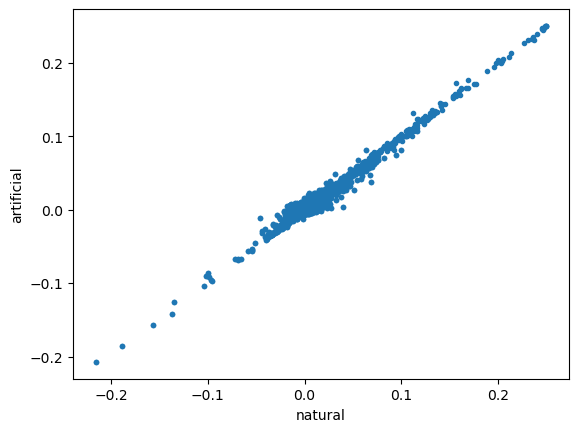

In [27]:
plot(c[:],cs[:],".")
xlabel("natural")
ylabel("artificial");


## 4. Infer the $(Qs, Ks)$ matrices from multiple families and the $V$ matrix shared among them. Then infer the contacts.

For lack of a different small dataset in the repository, we use the same family twice. 

In [28]:
out_multi = multi_trainer(["../data/PF00014.fasta","../data/PF00014.fasta"],[30,30],128,[5,5]);

removing duplicate sequences... done: 4915 -> 3617
θ = 0.3581129355126962 threshold = 18.0
M = 3617 N = 53 Meff = 1435.5651179248357
removing duplicate sequences... done: 4915 -> 3617
θ = 0.3581129355126962 threshold = 18.0
M = 3617 N = 53 Meff = 1435.5651179248357
Epoch 1 loss PF1 = 646.74147 loss PF2 = 646.51771 -> Total loss = 1293.25918
Epoch 2 loss PF1 = 199.01757 loss PF2 = 198.9858 -> Total loss = 398.00337
Epoch 3 loss PF1 = 109.2825 loss PF2 = 109.30106 -> Total loss = 218.58356
Epoch 4 loss PF1 = 95.77299 loss PF2 = 95.69052 -> Total loss = 191.46351
Epoch 5 loss PF1 = 93.03558 loss PF2 = 92.94347 -> Total loss = 185.97905
Epoch 6 loss PF1 = 91.34474 loss PF2 = 91.27579 -> Total loss = 182.62053
Epoch 7 loss PF1 = 90.33879 loss PF2 = 90.30036 -> Total loss = 180.63915
Epoch 8 loss PF1 = 89.29035 loss PF2 = 89.17353 -> Total loss = 178.46388
Epoch 9 loss PF1 = 88.51603 loss PF2 = 88.44522 -> Total loss = 176.96125
Epoch 10 loss PF1 = 87.76082 loss PF2 = 87.69095 -> Total loss 

In [32]:
out_multi.m.Qs[1] #1st family Query matrix

128×5×53 Array{Float64, 3}:
[:, :, 1] =
 -0.154299  -0.7309      0.109024    0.460021    0.203091
  1.50308    0.520898    1.14829     1.96223     0.341205
  0.648114   0.655375    0.735323   -1.34495    -0.303389
 -0.692407   1.13574     0.815456    1.00709    -1.05771
  0.242213   0.0959595   0.123461    0.416761    0.218375
  0.355264   1.02401     1.07229     0.867211    0.385941
  0.026512   0.53048     0.0596028   0.0568061   0.221604
 -0.288399   1.05675    -0.136575    1.43842    -0.30513
 -0.144035  -1.182       1.59839     0.0940361   1.91555
 -0.868393   0.85827     0.479125    0.512052    0.316042
  0.82486    0.0613205  -1.20122     0.233958    0.302382
  0.485721   0.860079    1.26655     0.275238    1.66515
 -0.127863  -0.485773    1.49477     0.0317195   1.1161
  ⋮                                             
  0.9641     0.98158     0.594004    1.40207     0.994401
  0.254263   0.857176    0.199283    0.902815    1.02437
  1.20097    1.4749      1.72639     0.455946   

In [37]:
s1 = score(out_multi.m.Qs[1],out_multi.m.Ks[1], out_multi.m.V) #first family contact score
s2 = score(out_multi.m.Qs[2],out_multi.m.Ks[2], out_multi.m.V) #first family contact score;
[s1 s2]

1128×2 Matrix{Tuple{Int64, Int64, Float64}}:
 (11, 35, 19.8907)    (11, 35, 20.3089)
 (17, 41, 10.8573)    (21, 28, 10.8599)
 (21, 28, 10.5007)    (17, 41, 10.3173)
 (6, 19, 7.64135)     (6, 19, 8.31466)
 (17, 43, 6.87925)    (17, 43, 7.18725)
 (14, 31, 5.03947)    (14, 31, 4.80408)
 (19, 28, 4.52062)    (19, 28, 4.10682)
 (14, 33, 3.4984)     (10, 33, 4.07191)
 (10, 33, 3.49611)    (14, 33, 3.68128)
 (4, 39, 3.36423)     (1, 39, 3.60463)
 (16, 29, 3.35976)    (18, 45, 3.51198)
 (18, 45, 3.13711)    (8, 33, 2.91235)
 (1, 39, 3.11394)     (4, 39, 2.67261)
 ⋮                    
 (11, 45, -0.885402)  (11, 19, -0.8859)
 (33, 41, -0.891839)  (7, 28, -0.886471)
 (11, 41, -0.898113)  (1, 45, -0.886918)
 (11, 17, -0.921126)  (15, 41, -0.89556)
 (13, 45, -0.931107)  (19, 33, -0.89696)
 (11, 28, -0.938596)  (28, 41, -0.911571)
 (28, 43, -0.999947)  (11, 45, -0.949715)
 (17, 49, -1.0217)    (17, 49, -0.96823)
 (19, 33, -1.08215)   (15, 28, -1.02505)
 (15, 28, -1.16681)   (28, 43, -1.10877)
 (28,

In [44]:
truth1 = AttentionDCA.compute_actualPPV("../data/PF00014_struct.dat");
ppv1_frobenious = compute_PPV(s1, "../data/PF00014_struct.dat");

truth2 = AttentionDCA.compute_actualPPV("../data/PF00014_struct.dat");
ppv2_frobenious = compute_PPV(s2, "../data/PF00014_struct.dat");

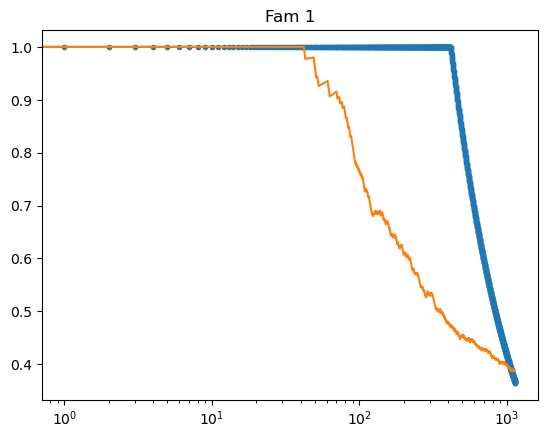

In [45]:
semilogx(truth1, ".-");
semilogx(ppv1_frobenious); title("Fam 1");

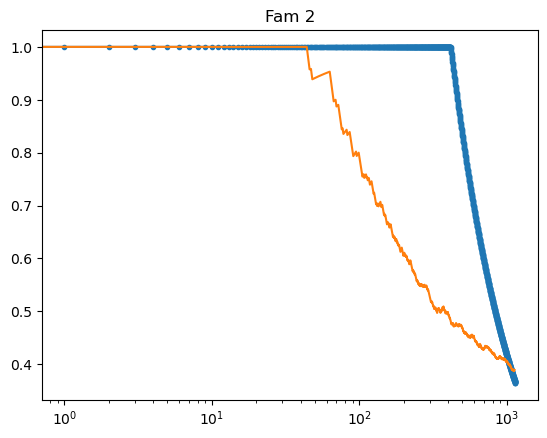

In [46]:
semilogx(truth2, ".-");
semilogx(ppv2_frobenious); title("Fam 2");